In [2]:

import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.base import clone
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import TimeSeriesSplit
import joblib
import matplotlib.pyplot as plt
import os

# Set environment variable to prevent XGBoost device mismatch warning
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# /kaggle/input/burnout-datathon-ieeecsmuj/test.csv
# Load data
train = pd.read_csv('/kaggle/input/burnout-datathon-ieeecsmuj/train.csv')
val = pd.read_csv('/kaggle/input/burnout-datathon-ieeecsmuj/val.csv')
test = pd.read_csv('/kaggle/input/burnout-datathon-ieeecsmuj/test.csv')

# Feature engineering with improved safety
def create_features(df):
    # Temporal features
    df['season_progress'] = df['year_x'] - df['min_year']
    df['career_phase'] = (df['year_x'] - df['min_year']) / (df['years_active'].replace(0, np.nan) + 1e-6)
    
    # Team performance metrics
    df['team_success_rate'] = df['podiums'] / (df['starts'].replace(0, np.nan) + 1e-6)
    df['team_reliability'] = df['finishes'] / (df['starts'].replace(0, np.nan) + 1e-6)
    
    # Tire dynamics
    df['tire_wear_ratio'] = df['Tire_Degradation_Factor_per_Lap'] * df['Laps']
    df['compound_aggressiveness'] = np.where(
        df['Tire_Compound_Front'] == 'Soft', 1.2,
        np.where(df['Tire_Compound_Front'] == 'Medium', 1.0, 0.8)
    )
    
    # Track difficulty
    df['speed_load'] = df['Avg_Speed_kmh'] / (df['Circuit_Length_km'].replace(0, np.nan) + 1e-6)
    df['corner_intensity'] = df['Corners_per_Lap'] / (df['Circuit_Length_km'].replace(0, np.nan) + 1e-6)
    
    # Session progression
    session_order = {'FP1':1, 'FP2':2, 'FP3':3, 'FP4':4, 
                    'Qualifying':5, 'Sprint':6, 'Race':7}
    df['session_importance'] = df['Session'].map(session_order).fillna(0)
    
    # List of all potential numerical columns
    numerical_cols = ['Circuit_Length_km', 'Laps', 'Avg_Speed_kmh', 
                     'Tire_Degradation_Factor_per_Lap', 'Ambient_Temperature_Celsius',
                     'Humidity_%', 'points', 'Championship_Points', 'Corners_per_Lap',
                     'Pit_Stop_Duration_Seconds', 'Track_Temperature_Celsius', 'air',
                     'ground', 'starts', 'finishes', 'with_points', 'podiums', 'wins',
                     'min_year', 'max_year', 'years_active', 'year_x',
                     'season_progress', 'career_phase', 'team_success_rate', 
                     'team_reliability', 'tire_wear_ratio', 'compound_aggressiveness',
                     'speed_load', 'corner_intensity', 'session_importance']
    
    # Convert to numeric and fill NaN with 0
    for col in numerical_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
            
    return df

# Apply feature engineering
train = create_features(train)
val = create_features(val)
test = create_features(test)

# Define feature groups
high_cardinality = ['rider_name', 'circuit_name', 'team_name', 'shortname', 'bike_name']
ordinal_features = ['Tire_Compound_Front', 'Tire_Compound_Rear', 
                   'Grid_Position', 'Championship_Position']
nominal_features = ['category_x', 'Track_Condition', 'Penalty', 
                   'weather', 'track', 'Session']

numerical_features = [
    'Circuit_Length_km', 'Laps', 'Avg_Speed_kmh', 'Tire_Degradation_Factor_per_Lap',
    'season_progress', 'career_phase', 'team_success_rate', 'team_reliability',
    'tire_wear_ratio', 'compound_aggressiveness', 'speed_load', 'corner_intensity',
    'session_importance', 'Ambient_Temperature_Celsius', 'Humidity_%', 'points',
    'Championship_Points', 'Corners_per_Lap', 'Pit_Stop_Duration_Seconds',
    'Track_Temperature_Celsius', 'air', 'ground', 'starts', 'finishes', 'with_points',
    'podiums', 'wins', 'min_year', 'max_year', 'years_active', 'year_x'
]

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('target_enc', OrdinalEncoder(
        handle_unknown='use_encoded_value', 
        unknown_value=-1
    ), high_cardinality),
    ('ordinal', OrdinalEncoder(
        categories=[
            ['Hard','Medium','Soft'], 
            ['Hard','Medium','Soft'],
            list(range(1, 26)),  # Grid positions
            list(range(1, 31))   # Championship positions
        ],
        handle_unknown='use_encoded_value',
        unknown_value=-1
    ), ordinal_features),
    ('onehot', OneHotEncoder(handle_unknown='ignore'), nominal_features),
    ('num', 'passthrough', numerical_features)
])

# Prepare data
features_used = high_cardinality + ordinal_features + nominal_features + numerical_features
X_train = train[features_used]
y_train = train['Lap_Time_Seconds']
X_val = val[features_used]
y_val = val['Lap_Time_Seconds']
X_test = test[features_used]

# Combine train and val for final training
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

# Preprocess all data at once
preprocessor.fit(X_train_val)
X_train_val_trans = preprocessor.transform(X_train_val)
X_test_trans = preprocessor.transform(X_test)

# Create validation split for plotting
split_index = int(len(X_train_val_trans) * 0.9)  # 90% train, 10% validation
X_final_train = X_train_val_trans[:split_index]
y_final_train = y_train_val.iloc[:split_index]
X_final_val = X_train_val_trans[split_index:]
y_final_val = y_train_val.iloc[split_index:]

# Configure final model
final_model = XGBRegressor(
    tree_method='hist',
    device='cuda',
    n_estimators=20000,
    learning_rate=0.03770760297401682,
    max_depth=20,
    subsample=0.6936774881064425,
    colsample_bytree=0.851962030829581,
    gamma=0.146963904565,
    reg_alpha=1.53108214125,
    reg_lambda=1.9924755681,
    eval_metric='rmse',
    early_stopping_rounds=50
)

# Train with validation set for learning curve
history = final_model.fit(
    X_final_train, y_final_train,
    eval_set=[(X_final_val, y_final_val)],
    verbose=100  # Print progress every 10 iterations
)

# Plot learning curve
results = final_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

plt.figure(figsize=(12, 6))
plt.plot(x_axis, results['validation_0']['rmse'], label='Validation')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('Epochs')
plt.title('XGBoost Learning Curve')
plt.savefig('learning_curve.png')
plt.close()

# Plot feature importance
plt.figure(figsize=(16, 12))
plot_importance(final_model, max_num_features=30)
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.close()

# Retrain on full dataset
final_model = XGBRegressor(
    tree_method='hist',
    device='cuda',
    n_estimators=final_model.best_iteration,
    learning_rate=0.025,
    max_depth=9,
    subsample=0.75,
    colsample_bytree=0.85,
    gamma=0.1,
    reg_alpha=0.5,
    reg_lambda=0.5,
    eval_metric='rmse'
)

final_model.fit(X_train_val_trans, y_train_val)

# Generate predictions
# Set device to CPU for prediction to avoid device mismatch
final_model.set_params(device='cpu')
test_preds = final_model.predict(X_test_trans)

# Create submission
submission = pd.DataFrame({
    'Unique ID': test['Unique ID'],
    'Lap_Time_Seconds': np.round(test_preds, 3)
})
submission.to_csv('solution.csv', index=False)

# Save model artifacts
joblib.dump(preprocessor, 'preprocessor.pkl')
joblib.dump(final_model, 'final_model.pkl')

print("Training completed successfully!")
print(f"Learning curve saved as 'learning_curve.png'")
print(f"Feature importance plot saved as 'feature_importance.png'")
print(f"Submission file saved as 'solution.csv'")

[0]	validation_0-rmse:11.33351
[100]	validation_0-rmse:1.76940
[200]	validation_0-rmse:0.37775
[300]	validation_0-rmse:0.12755
[400]	validation_0-rmse:0.11570
[483]	validation_0-rmse:0.11464
Training completed successfully!
Learning curve saved as 'learning_curve.png'
Feature importance plot saved as 'feature_importance.png'
Submission file saved as 'solution.csv'


<Figure size 1600x1200 with 0 Axes>

In [6]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import TimeSeriesSplit
import joblib
import matplotlib.pyplot as plt
import optuna
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Load data/kaggle/input/burnout-datathon-ieeecsmuj/test.csv
train = pd.read_csv('/kaggle/input/burnout-datathon-ieeecsmuj/train.csv')
val = pd.read_csv('/kaggle/input/burnout-datathon-ieeecsmuj/val.csv')
test = pd.read_csv('/kaggle/input/burnout-datathon-ieeecsmuj/test.csv')

# Advanced feature engineering
def create_features(df):
    # Temporal features
    df['years_since_debut'] = df['year_x'] - df['min_year']
    df['career_phase'] = df['years_since_debut'] / (df['years_active'] + 1e-6)
    
    # Performance features
    df['podium_rate'] = df['podiums'] / (df['starts'] + 1e-6)
    df['finish_rate'] = df['finishes'] / (df['starts'] + 1e-6)
    df['win_rate'] = df['wins'] / (df['starts'] + 1e-6)
    
    # Tire and track dynamics
    df['tire_wear_effect'] = df['Tire_Degradation_Factor_per_Lap'] * df['Laps'] * df['Circuit_Length_km']
    df['compound_aggressiveness'] = np.select(
        [
            df['Tire_Compound_Front'] == 'Soft',
            df['Tire_Compound_Front'] == 'Medium',
            df['Tire_Compound_Front'] == 'Hard'
        ],
        [1.2, 1.0, 0.8],
        default=1.0
    )
    
    # Speed and corner dynamics
    df['speed_intensity'] = df['Avg_Speed_kmh'] / df['Circuit_Length_km']
    df['corner_intensity'] = df['Corners_per_Lap'] / df['Circuit_Length_km']
    df['speed_corner_ratio'] = df['Avg_Speed_kmh'] / (df['Corners_per_Lap'] + 1e-6)
    
    # Session importance
    session_order = {'FP1':1, 'FP2':2, 'FP3':3, 'FP4':4, 
                    'Qualifying':5, 'Sprint':6, 'Race':7}
    df['session_importance'] = df['Session'].map(session_order).fillna(0)
    
    # Weather effects
    df['temp_humidity_effect'] = df['Ambient_Temperature_Celsius'] * df['Humidity_%'] / 100
    df['track_temp_effect'] = df['Track_Temperature_Celsius'] - df['Ambient_Temperature_Celsius']
    
    # Rider-team synergy
    df['rider_team_experience'] = df['year_x'] - df.groupby(['rider_name', 'team_name'])['year_x'].transform('min')
    # df = df.sort_values('year_x')
    # group = df.groupby(['rider_name', 'team_name'])
    # df['rider_team_experience'] = group['year_x'].expanding().apply(lambda x: x.iloc[-1] - x.iloc[0], raw=False)

    # Recent performance
    df['recent_points'] = df.groupby('rider_name')['points'].transform(lambda x: x.rolling(3, min_periods=1).mean())
    #=================================================
    # df['tire_temp_diff'] = df['Track_Temperature_Celsius'] - {
    #     'Soft': 30, 'Medium': 40, 'Hard': 50
    # }[df['Tire_Compound_Front']]
    df['tire_temp_diff'] = df['Track_Temperature_Celsius'] - df['Tire_Compound_Front'].map({
        'Soft': 30, 
        'Medium': 40, 
        'Hard': 50
    })
        
    df['rain_effect'] = np.where(df['weather'] == 'Raining', 
                                 df['Humidity_%'] * df['Tire_Degradation_Factor_per_Lap'], 
                                 0)
    #=================================================

    # Numerical columns to process
    num_cols = [
        'Circuit_Length_km', 'Laps', 'Avg_Speed_kmh', 'Tire_Degradation_Factor_per_Lap',
        'Ambient_Temperature_Celsius', 'Humidity_%', 'points', 'Championship_Points',
        'Corners_per_Lap', 'Pit_Stop_Duration_Seconds', 'Track_Temperature_Celsius',
        'years_since_debut', 'career_phase', 'podium_rate', 'finish_rate', 'win_rate',
        'tire_wear_effect', 'compound_aggressiveness', 'speed_intensity', 
        'corner_intensity', 'speed_corner_ratio', 'session_importance',
        'temp_humidity_effect', 'track_temp_effect', 'rider_team_experience', 'recent_points','tire_temp_diff', 'rain_effect', 'recent_points'
    ]
    
    # Process numerical columns
    for col in num_cols:
        if col in df.columns:
            # Handle infinite values and NaNs
            df[col] = df[col].replace([np.inf, -np.inf], np.nan)
            mean_val = df[col].mean()
            df[col] = df[col].fillna(mean_val if not np.isnan(mean_val) else 0)
            
    return df

# Apply feature engineering
train = create_features(train)
val = create_features(val)
test = create_features(test)

# Define feature groups
high_cardinality = ['rider_name', 'circuit_name', 'team_name', 'shortname', 'bike_name']
ordinal_features = ['Tire_Compound_Front', 'Tire_Compound_Rear', 
                   'Grid_Position', 'Championship_Position']
nominal_features = ['category_x', 'Track_Condition', 'Penalty', 
                   'weather', 'track', 'Session']

numerical_features = [
    'Circuit_Length_km', 'Laps', 'Avg_Speed_kmh', 'Tire_Degradation_Factor_per_Lap',
    'Ambient_Temperature_Celsius', 'Humidity_%', 'points', 'Championship_Points',
    'Corners_per_Lap', 'Pit_Stop_Duration_Seconds', 'Track_Temperature_Celsius',
    'years_since_debut', 'career_phase', 'podium_rate', 'finish_rate', 'win_rate',
    'tire_wear_effect', 'compound_aggressiveness', 'speed_intensity', 
    'corner_intensity', 'speed_corner_ratio', 'session_importance',
    'temp_humidity_effect', 'track_temp_effect', 'rider_team_experience', 'recent_points'
]

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('target_enc', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 
     high_cardinality),
    ('ordinal', OrdinalEncoder(
        categories=[
            ['Hard','Medium','Soft'], 
            ['Hard','Medium','Soft'],
            list(range(1, 26)),  # Grid positions   
            list(range(1, 31))   # Championship positions
        ], 
        handle_unknown='use_encoded_value',
        unknown_value=-1
    ), ordinal_features),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), nominal_features),
    ('num', 'passthrough', numerical_features)
])

# Prepare data
features_used = high_cardinality + ordinal_features + nominal_features + numerical_features
X_train = train[features_used]
y_train = train['Lap_Time_Seconds']
X_val = val[features_used]
y_val = val['Lap_Time_Seconds']
X_test = test[features_used]

# Combine train and val
X_full = pd.concat([X_train, X_val])
y_full = pd.concat([y_train, y_val])

# Preprocess data
preprocessor.fit(X_full)
X_train_pre = preprocessor.transform(X_train)
X_val_pre = preprocessor.transform(X_val)
X_full_pre = preprocessor.transform(X_full)
X_test_pre = preprocessor.transform(X_test)

# Hyperparameter optimization with Optuna
def objective(trial):
    params = {
        'tree_method': 'hist',
        'device': 'cuda',
        'n_estimators': 5000,
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth',10, 20),
        'subsample': trial.suggest_float('subsample', 0.4, 0.8),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'eval_metric': 'rmse',
        'early_stopping_rounds': 100
    }
    
    model = XGBRegressor(**params)
    
    model.fit(
        X_train_pre, y_train,
        eval_set=[(X_val_pre, y_val)],
        verbose=False
    )
    
    # Get best score
    best_rmse = min(model.evals_result()['validation_0']['rmse'])
    return best_rmse

# Run optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, timeout=3600)  # 1 hour timeout

# Get best parameters
best_params = study.best_params
print(f"Best parameters: {best_params}")
print(f"Best validation RMSE: {study.best_value:.6f}")

# Train final model with best parameters
final_model = XGBRegressor(
    **best_params,
    tree_method='hist',
    device='cuda'
)

# Train with early stopping
final_model.fit(
    X_train_pre, y_train,
    eval_set=[(X_val_pre, y_val)],
    verbose=100
)

# Plot learning curve
results = final_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

plt.figure(figsize=(12, 6))
plt.plot(x_axis, results['validation_0']['rmse'], label='Validation')
plt.axhline(y=study.best_value, color='r', linestyle='--', label=f'Best RMSE: {study.best_value:.6f}')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('Epochs')
plt.title('XGBoost Learning Curve')
plt.savefig('learning_curve.png')
plt.close()

# Plot feature importance
plt.figure(figsize=(16, 12))
plot_importance(final_model, max_num_features=30)
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.close()

# Generate predictions
test_preds = final_model.predict(X_test_pre)

# Create submission
submission = pd.DataFrame({
    'Unique ID': test['Unique ID'],
    'Lap_Time_Seconds': np.round(test_preds, 6)  # More precision
})
submission.to_csv('solution.csv', index=False)

# # Save model artifacts
# joblib.dump(preprocessor, 'preprocessor.pkl')
# joblib.dump(final_model, 'final_model.pkl')

# print(f"Final model trained with validation RMSE: {study.best_value:.6f}")
# print("Submission file created with high-precision predictions")

[I 2025-06-14 15:31:39,610] A new study created in memory with name: no-name-c5110ed3-c6e3-45de-92e7-ce48a7ffd688
[I 2025-06-14 15:36:04,657] Trial 0 finished with value: 0.2950977346183734 and parameters: {'learning_rate': 0.03404520225692639, 'max_depth': 12, 'subsample': 0.5378664558053667, 'colsample_bytree': 0.7312894225838537, 'gamma': 0.1592056224129913, 'reg_alpha': 0.18087492390629234, 'reg_lambda': 3.766542462825125}. Best is trial 0 with value: 0.2950977346183734.
[I 2025-06-14 15:43:20,095] Trial 1 finished with value: 0.1319071050942873 and parameters: {'learning_rate': 0.011402872059158305, 'max_depth': 18, 'subsample': 0.6627781711580402, 'colsample_bytree': 0.876682342023657, 'gamma': 0.10717525341150558, 'reg_alpha': 0.6025606773970926, 'reg_lambda': 2.1170292796479124}. Best is trial 1 with value: 0.1319071050942873.
[I 2025-06-14 15:48:31,438] Trial 2 finished with value: 0.32998954254633905 and parameters: {'learning_rate': 0.012401106600149989, 'max_depth': 15, 'su

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from xgboost import XGBRegressor, plot_importance
import joblib
import matplotlib.pyplot as plt
import os

# Set environment variables
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Load data
train = pd.read_csv('/kaggle/input/burnout-datathon-ieeecsmuj/train.csv')
val = pd.read_csv('/kaggle/input/burnout-datathon-ieeecsmuj/val.csv')
test = pd.read_csv('/kaggle/input/burnout-datathon-ieeecsmuj/test.csv')

# Advanced feature engineering
def create_features(df):
    # Temporal features
    df['years_since_debut'] = df['year_x'] - df['min_year']
    df['career_phase'] = df['years_since_debut'] / (df['years_active'].replace(0, np.nan) + 1e-6)
    
    # Performance features
    df['podium_rate'] = df['podiums'] / (df['starts'].replace(0, np.nan) + 1e-6)
    df['finish_rate'] = df['finishes'] / (df['starts'].replace(0, np.nan) + 1e-6)
    df['win_rate'] = df['wins'] / (df['starts'].replace(0, np.nan) + 1e-6)
    
    # Tire and track dynamics
    df['tire_wear_effect'] = df['Tire_Degradation_Factor_per_Lap'] * df['Laps'] * df['Circuit_Length_km']
    df['compound_aggressiveness'] = np.select(
        [
            df['Tire_Compound_Front'] == 'Soft',
            df['Tire_Compound_Front'] == 'Medium',
            df['Tire_Compound_Front'] == 'Hard'
        ],
        [1.2, 1.0, 0.8],
        default=1.0
    )
    
    # Speed and corner dynamics
    df['speed_intensity'] = df['Avg_Speed_kmh'] / (df['Circuit_Length_km'] + 1e-6)
    df['corner_intensity'] = df['Corners_per_Lap'] / (df['Circuit_Length_km'] + 1e-6)
    df['speed_corner_ratio'] = df['Avg_Speed_kmh'] / (df['Corners_per_Lap'] + 1e-6)
    
    # Session importance
    session_order = {'FP1':1, 'FP2':2, 'FP3':3, 'FP4':4, 
                    'Qualifying':5, 'Sprint':6, 'Race':7}
    df['session_importance'] = df['Session'].map(session_order).fillna(0)
    
    # Weather effects
    df['temp_humidity_effect'] = df['Ambient_Temperature_Celsius'] * df['Humidity_%'] / 100
    df['track_temp_effect'] = df['Track_Temperature_Celsius'] - df['Ambient_Temperature_Celsius']
    
    # Rider-team synergy
    df['rider_team_experience'] = df.groupby(['rider_name', 'team_name'])['year_x'].transform(lambda x: x - x.min())
    
    # Recent performance
    df['recent_points'] = df.groupby('rider_name')['points'].transform(lambda x: x.rolling(3, min_periods=1).mean())
    
    # Tire temperature
    compound_map = {'Soft': 30, 'Medium': 40, 'Hard': 50}
    df['tire_temp_diff'] = df['Track_Temperature_Celsius'] - df['Tire_Compound_Front'].map(compound_map)
    
    # Rain effect
    df['rain_effect'] = np.where(df['weather'] == 'Raining', 
                                 df['Humidity_%'] * df['Tire_Degradation_Factor_per_Lap'], 
                                 0)
    
    # Numerical columns to process
    num_cols = [
        'Circuit_Length_km', 'Laps', 'Avg_Speed_kmh', 'Tire_Degradation_Factor_per_Lap',
        'Ambient_Temperature_Celsius', 'Humidity_%', 'points', 'Championship_Points',
        'Corners_per_Lap', 'Pit_Stop_Duration_Seconds', 'Track_Temperature_Celsius',
        'years_since_debut', 'career_phase', 'podium_rate', 'finish_rate', 'win_rate',
        'tire_wear_effect', 'compound_aggressiveness', 'speed_intensity', 
        'corner_intensity', 'speed_corner_ratio', 'session_importance',
        'temp_humidity_effect', 'track_temp_effect', 'rider_team_experience', 'recent_points',
        'tire_temp_diff', 'rain_effect'
    ]
    
    # Process numerical columns
    for col in num_cols:
        if col in df.columns:
            # Handle infinite values and NaNs
            df[col] = df[col].replace([np.inf, -np.inf], np.nan)
            mean_val = df[col].mean()
            df[col] = df[col].fillna(mean_val if not np.isnan(mean_val) else 0)
            
    return df

# Apply feature engineering
train = create_features(train)
val = create_features(val)
test = create_features(test)

# Define feature groups
high_cardinality = ['rider_name', 'circuit_name', 'team_name', 'shortname', 'bike_name']
ordinal_features = ['Tire_Compound_Front', 'Tire_Compound_Rear', 
                   'Grid_Position', 'Championship_Position']
nominal_features = ['category_x', 'Track_Condition', 'Penalty', 
                   'weather', 'track', 'Session']

numerical_features = [
    'Circuit_Length_km', 'Laps', 'Avg_Speed_kmh', 'Tire_Degradation_Factor_per_Lap',
    'Ambient_Temperature_Celsius', 'Humidity_%', 'points', 'Championship_Points',
    'Corners_per_Lap', 'Pit_Stop_Duration_Seconds', 'Track_Temperature_Celsius',
    'years_since_debut', 'career_phase', 'podium_rate', 'finish_rate', 'win_rate',
    'tire_wear_effect', 'compound_aggressiveness', 'speed_intensity', 
    'corner_intensity', 'speed_corner_ratio', 'session_importance',
    'temp_humidity_effect', 'track_temp_effect', 'rider_team_experience', 'recent_points',
    'tire_temp_diff', 'rain_effect'
]

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('target_enc', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 
     high_cardinality),
    ('ordinal', OrdinalEncoder(
        categories=[
            ['Hard','Medium','Soft'], 
            ['Hard','Medium','Soft'],
            list(range(1, 26)),  # Grid positions
            list(range(1, 31))   # Championship positions
        ], 
        handle_unknown='use_encoded_value',
        unknown_value=-1
    ), ordinal_features),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), nominal_features),
    ('num', 'passthrough', numerical_features)
])

# Prepare data
features_used = high_cardinality + ordinal_features + nominal_features + numerical_features
X_train = train[features_used]
y_train = train['Lap_Time_Seconds']
X_val = val[features_used]
y_val = val['Lap_Time_Seconds']
X_test = test[features_used]

# Combine train and val
X_full = pd.concat([X_train, X_val])
y_full = pd.concat([y_train, y_val])

# Preprocess data
preprocessor.fit(X_full)
X_train_pre = preprocessor.transform(X_train)
X_val_pre = preprocessor.transform(X_val)
X_full_pre = preprocessor.transform(X_full)
X_test_pre = preprocessor.transform(X_test)

# Best hyperparameters from Optuna trial
best_params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "tree_method": "hist",
    "device": "cuda",
    "enable_categorical": False,
    "seed": 42,
    "n_estimators": 10000,
    "learning_rate": 0.011402872059158305,
    "max_depth": 18,
    "subsample": 0.6627781711580402,
    "colsample_bytree": 0.876682342023657,
    "gamma": 0.10717525341150558,
    "reg_alpha": 0.6025606773970926,
    "reg_lambda": 2.1170292796479124,
    "early_stopping_rounds": 100
}

# Train model with early stopping
model = XGBRegressor(**best_params)
model.fit(
    X_train_pre, y_train,
    eval_set=[(X_val_pre, y_val)],
    verbose=100
)

# Get best iteration and RMSE
best_iteration = model.best_iteration
best_rmse = model.best_score
print(f"Best iteration: {best_iteration}")
print(f"Best validation RMSE: {best_rmse}")

# Retrain on full dataset with optimal iterations
final_model = XGBRegressor(
    **{k: v for k, v in best_params.items() if k not in ['early_stopping_rounds']},
    n_estimators=best_iteration
)
final_model.fit(X_full_pre, y_full)

# Plot learning curve
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

plt.figure(figsize=(12, 6))
plt.plot(x_axis, results['validation_0']['rmse'], label='Validation')
plt.axhline(y=best_rmse, color='r', linestyle='--', label=f'Best RMSE: {best_rmse:.6f}')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('Epochs')
plt.title('XGBoost Learning Curve')
plt.savefig('learning_curve.png')
plt.close()

# Plot feature importance
plt.figure(figsize=(16, 12))
plot_importance(model, max_num_features=30)
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.close()

# Generate predictions
test_preds = final_model.predict(X_test_pre)

# Create submission
submission = pd.DataFrame({
    'Unique ID': test['Unique ID'],
    'Lap_Time_Seconds': np.round(test_preds, 6)
})
submission.to_csv('solution.csv', index=False)

print("Training completed successfully!")
print(f"Best validation RMSE: {best_rmse:.6f}")
print(f"Used {best_iteration} iterations for final model")
print(f"Learning curve saved as 'learning_curve.png'")
print(f"Feature importance plot saved as 'feature_importance.png'")
print(f"Submission file saved as 'solution.csv'")

In [1]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from xgboost import XGBRegressor, plot_importance
import joblib
import matplotlib.pyplot as plt
import os

# Set environment variables
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Load data
train = pd.read_csv('/kaggle/input/burnout-datathon-ieeecsmuj/train.csv')
val = pd.read_csv('/kaggle/input/burnout-datathon-ieeecsmuj/val.csv')
test = pd.read_csv('/kaggle/input/burnout-datathon-ieeecsmuj/test.csv')

# Advanced feature engineering
def create_features(df):
    # Temporal features
    df['years_since_debut'] = df['year_x'] - df['min_year']
    df['career_phase'] = df['years_since_debut'] / (df['years_active'].replace(0, np.nan) + 1e-6)
    
    # Performance features
    df['podium_rate'] = df['podiums'] / (df['starts'].replace(0, np.nan) + 1e-6)
    df['finish_rate'] = df['finishes'] / (df['starts'].replace(0, np.nan) + 1e-6)
    df['win_rate'] = df['wins'] / (df['starts'].replace(0, np.nan) + 1e-6)
    
    # Tire and track dynamics
    df['tire_wear_effect'] = df['Tire_Degradation_Factor_per_Lap'] * df['Laps'] * df['Circuit_Length_km']
    df['compound_aggressiveness'] = np.select(
        [
            df['Tire_Compound_Front'] == 'Soft',
            df['Tire_Compound_Front'] == 'Medium',
            df['Tire_Compound_Front'] == 'Hard'
        ],
        [1.2, 1.0, 0.8],
        default=1.0
    )
    
    # Speed and corner dynamics
    df['speed_intensity'] = df['Avg_Speed_kmh'] / (df['Circuit_Length_km'] + 1e-6)
    df['corner_intensity'] = df['Corners_per_Lap'] / (df['Circuit_Length_km'] + 1e-6)
    df['speed_corner_ratio'] = df['Avg_Speed_kmh'] / (df['Corners_per_Lap'] + 1e-6)
    
    # Session importance
    session_order = {'FP1':1, 'FP2':2, 'FP3':3, 'FP4':4, 
                    'Qualifying':5, 'Sprint':6, 'Race':7}
    df['session_importance'] = df['Session'].map(session_order).fillna(0)
    
    # Weather effects
    df['temp_humidity_effect'] = df['Ambient_Temperature_Celsius'] * df['Humidity_%'] / 100
    df['track_temp_effect'] = df['Track_Temperature_Celsius'] - df['Ambient_Temperature_Celsius']
    
    # Rider-team synergy
    df['rider_team_experience'] = df.groupby(['rider_name', 'team_name'])['year_x'].transform(lambda x: x - x.min())
    
    # Recent performance
    df['recent_points'] = df.groupby('rider_name')['points'].transform(lambda x: x.rolling(3, min_periods=1).mean())
    
    # Tire temperature
    compound_map = {'Soft': 30, 'Medium': 40, 'Hard': 50}
    df['tire_temp_diff'] = df['Track_Temperature_Celsius'] - df['Tire_Compound_Front'].map(compound_map)
    
    # Rain effect
    df['rain_effect'] = np.where(df['weather'] == 'Raining', 
                                 df['Humidity_%'] * df['Tire_Degradation_Factor_per_Lap'], 
                                 0)
    
    # Numerical columns to process
    num_cols = [
        'Circuit_Length_km', 'Laps', 'Avg_Speed_kmh', 'Tire_Degradation_Factor_per_Lap',
        'Ambient_Temperature_Celsius', 'Humidity_%', 'points', 'Championship_Points',
        'Corners_per_Lap', 'Pit_Stop_Duration_Seconds', 'Track_Temperature_Celsius',
        'years_since_debut', 'career_phase', 'podium_rate', 'finish_rate', 'win_rate',
        'tire_wear_effect', 'compound_aggressiveness', 'speed_intensity', 
        'corner_intensity', 'speed_corner_ratio', 'session_importance',
        'temp_humidity_effect', 'track_temp_effect', 'rider_team_experience', 'recent_points',
        'tire_temp_diff', 'rain_effect'
    ]
    
    # Process numerical columns
    for col in num_cols:
        if col in df.columns:
            # Handle infinite values and NaNs
            df[col] = df[col].replace([np.inf, -np.inf], np.nan)
            mean_val = df[col].mean()
            df[col] = df[col].fillna(mean_val if not np.isnan(mean_val) else 0)
            
    return df

# Apply feature engineering
train = create_features(train)
val = create_features(val)
test = create_features(test)

# Define feature groups
high_cardinality = ['rider_name', 'circuit_name', 'team_name', 'shortname', 'bike_name']
ordinal_features = ['Tire_Compound_Front', 'Tire_Compound_Rear', 
                   'Grid_Position', 'Championship_Position']
nominal_features = ['category_x', 'Track_Condition', 'Penalty', 
                   'weather', 'track', 'Session']

numerical_features = [
    'Circuit_Length_km', 'Laps', 'Avg_Speed_kmh', 'Tire_Degradation_Factor_per_Lap',
    'Ambient_Temperature_Celsius', 'Humidity_%', 'points', 'Championship_Points',
    'Corners_per_Lap', 'Pit_Stop_Duration_Seconds', 'Track_Temperature_Celsius',
    'years_since_debut', 'career_phase', 'podium_rate', 'finish_rate', 'win_rate',
    'tire_wear_effect', 'compound_aggressiveness', 'speed_intensity', 
    'corner_intensity', 'speed_corner_ratio', 'session_importance',
    'temp_humidity_effect', 'track_temp_effect', 'rider_team_experience', 'recent_points',
    'tire_temp_diff', 'rain_effect'
]

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('target_enc', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 
     high_cardinality),
    ('ordinal', OrdinalEncoder(
        categories=[
            ['Hard','Medium','Soft'], 
            ['Hard','Medium','Soft'],
            list(range(1, 26)),  # Grid positions
            list(range(1, 31))   # Championship positions
        ], 
        handle_unknown='use_encoded_value',
        unknown_value=-1
    ), ordinal_features),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), nominal_features),
    ('num', 'passthrough', numerical_features)
])

# Prepare data
features_used = high_cardinality + ordinal_features + nominal_features + numerical_features
X_train = train[features_used]
y_train = train['Lap_Time_Seconds']
X_val = val[features_used]
y_val = val['Lap_Time_Seconds']
X_test = test[features_used]

# Combine train and val
X_full = pd.concat([X_train, X_val])
y_full = pd.concat([y_train, y_val])

# Preprocess data
preprocessor.fit(X_full)
X_train_pre = preprocessor.transform(X_train)
X_val_pre = preprocessor.transform(X_val)
X_full_pre = preprocessor.transform(X_full)
X_test_pre = preprocessor.transform(X_test)

# Best hyperparameters from Optuna trial
best_params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "tree_method": "hist",
    "device": "cuda",
    "enable_categorical": False,
    "seed": 42,
    "n_estimators": 10000,
    "learning_rate": 0.011402872059158305,
    "max_depth": 18,
    "subsample": 0.6627781711580402,
    "colsample_bytree": 0.876682342023657,
    "gamma": 0.10717525341150558,
    "reg_alpha": 0.6025606773970926,
    "reg_lambda": 2.1170292796479124,
    "early_stopping_rounds": 100
}

# Train model with early stopping
model = XGBRegressor(**best_params)
model.fit(
    X_train_pre, y_train,
    eval_set=[(X_val_pre, y_val)],
    verbose=100
)

# Get best iteration and RMSE
best_iteration = model.best_iteration
best_rmse = model.best_score
print(f"Best iteration: {best_iteration}")
print(f"Best validation RMSE: {best_rmse}")

# Retrain on full dataset with optimal iterations
final_model = XGBRegressor(
    **{k: v for k, v in best_params.items() if k not in ['early_stopping_rounds']},
    n_estimators=best_iteration
)
final_model.fit(X_full_pre, y_full)

# Plot learning curve
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

plt.figure(figsize=(12, 6))
plt.plot(x_axis, results['validation_0']['rmse'], label='Validation')
plt.axhline(y=best_rmse, color='r', linestyle='--', label=f'Best RMSE: {best_rmse:.6f}')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('Epochs')
plt.title('XGBoost Learning Curve')
plt.savefig('learning_curve.png')
plt.close()

# Plot feature importance
plt.figure(figsize=(16, 12))
plot_importance(model, max_num_features=30)
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.close()

# Generate predictions
test_preds = final_model.predict(X_test_pre)

# Create submission
submission = pd.DataFrame({
    'Unique ID': test['Unique ID'],
    'Lap_Time_Seconds': np.round(test_preds, 6)
})
submission.to_csv('solution.csv', index=False)

print("Training completed successfully!")
print(f"Best validation RMSE: {best_rmse:.6f}")
print(f"Used {best_iteration} iterations for final model")
print(f"Learning curve saved as 'learning_curve.png'")
print(f"Feature importance plot saved as 'feature_importance.png'")
print(f"Submission file saved as 'solution.csv'")

[0]	validation_0-rmse:11.46130
[100]	validation_0-rmse:7.53693
[200]	validation_0-rmse:5.04374
[300]	validation_0-rmse:3.54819
[400]	validation_0-rmse:2.48362
[500]	validation_0-rmse:1.74803
[600]	validation_0-rmse:1.22379
[700]	validation_0-rmse:0.87520
[800]	validation_0-rmse:0.61089
[900]	validation_0-rmse:0.43354
[1000]	validation_0-rmse:0.32635
[1100]	validation_0-rmse:0.24995
[1200]	validation_0-rmse:0.20066
[1300]	validation_0-rmse:0.16915
[1400]	validation_0-rmse:0.15539
[1500]	validation_0-rmse:0.15099
[1600]	validation_0-rmse:0.14798
[1700]	validation_0-rmse:0.14728
[1800]	validation_0-rmse:0.14600
[1900]	validation_0-rmse:0.14572
[2000]	validation_0-rmse:0.14530
[2100]	validation_0-rmse:0.14505
[2200]	validation_0-rmse:0.14463
[2300]	validation_0-rmse:0.14443
[2400]	validation_0-rmse:0.14433
[2500]	validation_0-rmse:0.14412
[2600]	validation_0-rmse:0.14394
[2700]	validation_0-rmse:0.14375
[2800]	validation_0-rmse:0.14374
[2900]	validation_0-rmse:0.14367
[3000]	validation_0-r

TypeError: xgboost.sklearn.XGBRegressor() got multiple values for keyword argument 'n_estimators'

In [3]:
# Plot learning curve
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

plt.figure(figsize=(12, 6))
plt.plot(x_axis, results['validation_0']['rmse'], label='Validation')
plt.axhline(y=best_rmse, color='r', linestyle='--', label=f'Best RMSE: {best_rmse:.6f}')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('Epochs')
plt.title('XGBoost Learning Curve')
plt.savefig('learning_curve.png')
plt.close()

# Plot feature importance
plt.figure(figsize=(16, 12))
plot_importance(model, max_num_features=30)
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.close()

# Generate predictions
test_preds = model.predict(X_test_pre)

# Create submission
submission = pd.DataFrame({
    'Unique ID': test['Unique ID'],
    'Lap_Time_Seconds': np.round(test_preds, 6)
})
submission.to_csv('solution.csv', index=False)

print("Training completed successfully!")
print(f"Best validation RMSE: {best_rmse:.6f}")
print(f"Used {best_iteration} iterations for final model")
print(f"Learning curve saved as 'learning_curve.png'")
print(f"Feature importance plot saved as 'feature_importance.png'")
print(f"Submission file saved as 'solution.csv'")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [16:28:30] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Training completed successfully!
Best validation RMSE: 0.142009
Used 3839 iterations for final model
Learning curve saved as 'learning_curve.png'
Feature importance plot saved as 'feature_importance.png'
Submission file saved as 'solution.csv'


<Figure size 1600x1200 with 0 Axes>

DATASET OVERVIEW

=== Dataset Shape ===
Train shape: (1914056, 45)
Validation shape: (273437, 45)
Test shape: (546874, 44)
Combined shape: (2734367, 45)

=== First 5 Rows ===


,Unique ID,Rider_ID,category_x,Circuit_Length_km,Laps,Grid_Position,Avg_Speed_kmh,Track_Condition,Humidity_%,Tire_Compound_Front,Tire_Compound_Rear,Penalty,Championship_Points,Championship_Position,Session,year_x,sequence,rider,team,bike,position,points,shortname,circuit_name,rider_name,team_name,bike_name,Lap_Time_Seconds,Corners_per_Lap,Tire_Degradation_Factor_per_Lap,Pit_Stop_Duration_Seconds,Ambient_Temperature_Celsius,Track_Temperature_Celsius,weather,track,air,ground,starts,finishes,with_points,podiums,wins,min_year,max_year,years_active
0,1894944,2659,Moto2,4.874,22,17,264.66,Wet,61,Hard,Hard,+3s,100,20,FP3,2021,16,2639,615,258,9,7.0,EMI,Misano,"Ogura, Ai",IDEMITSU Honda Team Asia,Kalex,70.667,18,0.0042,4.09,23.0,27.3,Clear,Dry,23,35,53,45,41,4,0,2018,2021,4
1,23438,5205,Moto2,3.875,24,7,177.56,Wet,77,Soft,Medium,+5s,137,7,Race,1977,4,900,1,4,5,6.0,NAT,Imola,"North, Alan",?,Yamaha,103.497,23,0.0025,4.64,34.3,41.8,Raining,Wet,12,12,27,27,22,2,1,1975,1983,8
2,939678,7392,Moto3,5.647,25,5,317.74,Dry,87,Soft,Hard,DNF,43,17,Race,1985,2,1160,1,2,10,1.0,SPA,Jarama,"Biliotti, Fabio",?,Honda,78.400,19,0.0044,2.67,20.6,27.1,Cloudy,Dry,22,23,45,43,10,0,0,1982,1989,8
3,1196312,7894,Moto3,4.810,19,3,321.82,Wet,43,Soft,Hard,DNS,234,13,Race,2007,16,1693,206,15,11,5.0,AUS,Phillip Island,"Locatelli, Roberto",Metis Gilera,Gilera,81.338,12,0.0034,4.69,20.9,29.1,Clear,Dry,23,35,192,172,155,16,9,1994,2009,16
4,1033899,6163,MotoGP,5.809,25,21,239.92,Wet,47,Hard,Medium,DNS,306,8,FP3,2018,7,2450,568,6,6,10.0,CAT,Catalunya,"Binder, Brad",Red Bull KTM Ajo,KTM,108.626,23,0.0017,4.84,29.1,43.4,Cloudy,Dry,22,31,175,146,132,29,17,2011,2021,11



=== Data Types and Missing Values ===


,dtype,missing_values,missing_%,unique_values
Unique ID,int64,0,0.00,2734367
Rider_ID,int64,0,0.00,8999
category_x,object,0,0.00,3
Circuit_Length_km,float64,0,0.00,2401
Laps,int64,0,0.00,8
Grid_Position,int64,0,0.00,22
Avg_Speed_kmh,float64,0,0.00,19961
Track_Condition,object,0,0.00,2
Humidity_%,int64,0,0.00,60
Tire_Compound_Front,object,0,0.00,3



=== Missing Values Matrix ===


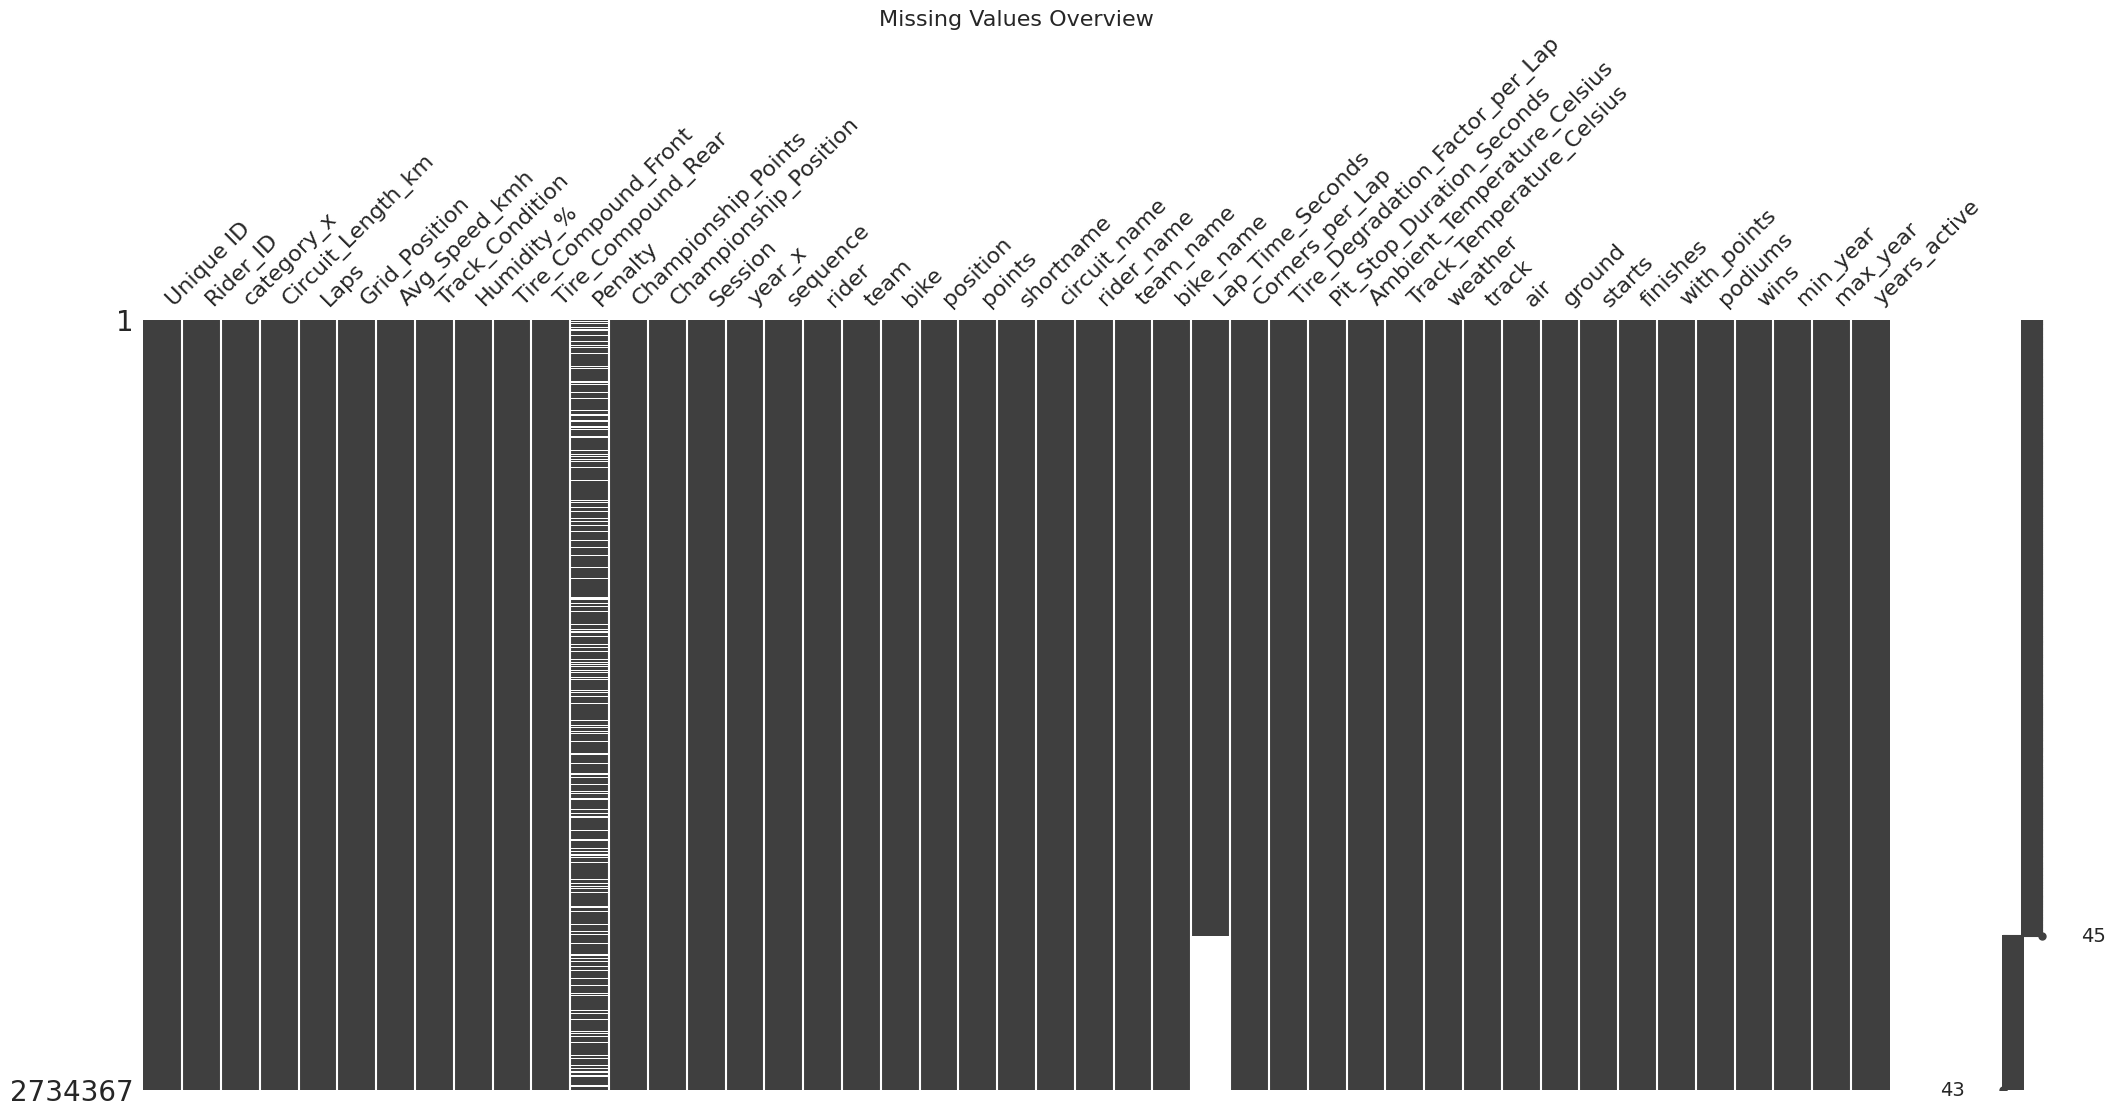


DESCRIPTIVE STATISTICS

=== Numerical Features Summary ===


,count,mean,std,min,25%,50%,75%,max
Unique ID,2734367.0,1.367183e+06,789343.906096,0.0000,683591.5000,1.367183e+06,2.050774e+06,2734366.000
Rider_ID,2734367.0,5.510203e+03,2596.957804,1000.0000,3260.0000,5.515000e+03,7.761000e+03,9998.000
Circuit_Length_km,2734367.0,4.701773e+00,0.691351,3.5000,4.1040,4.703000e+00,5.299000e+00,5.900
Laps,2734367.0,2.150255e+01,2.292961,18.0000,19.0000,2.200000e+01,2.400000e+01,25.000
Grid_Position,2734367.0,1.150087e+01,6.334648,1.0000,6.0000,1.200000e+01,1.700000e+01,22.000
Avg_Speed_kmh,2734367.0,2.496356e+02,57.744037,150.0000,199.3100,2.496500e+02,2.994950e+02,350.000
Humidity_%,2734367.0,5.951778e+01,17.336233,30.0000,44.0000,6.000000e+01,7.500000e+01,89.000
Championship_Points,2734367.0,1.744653e+02,100.963451,0.0000,87.0000,1.740000e+02,2.620000e+02,349.000
Championship_Position,2734367.0,1.255017e+01,6.914607,1.0000,7.0000,1.300000e+01,1.900000e+01,24.000
year_x,2734367.0,1.997911e+03,17.088262,1949.0000,1987.0000,2.001000e+03,2.012000e+03,2021.000



=== Categorical Features Summary ===

category_x:
category_x
Moto2     915979
MotoGP    912640
Moto3     905748
Name: count, dtype: int64

Track_Condition:
Track_Condition
Wet    1370675
Dry    1363692
Name: count, dtype: int64

Tire_Compound_Front:
Tire_Compound_Front
Medium    912995
Soft      911278
Hard      910094
Name: count, dtype: int64

Tire_Compound_Rear:
Tire_Compound_Rear
Soft      916317
Medium    912392
Hard      905658
Name: count, dtype: int64

Penalty:
Penalty
DNS             460335
+3s             458164
DNF             453612
Ride Through    452262
+5s             451527
Name: count, dtype: int64

Session:
Session
Race          393469
FP1           392405
FP3           392276
Qualifying    389781
FP2           389771
FP4           389059
Sprint        387606
Name: count, dtype: int64

shortname:
shortname
NED    203163
SPA    171204
FRA    168971
GBR    142544
JPN    119336
AUS    113529
GER    112338
ITA    109498
CZE    107295
CAT    102541
Name: count, dtype: int

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


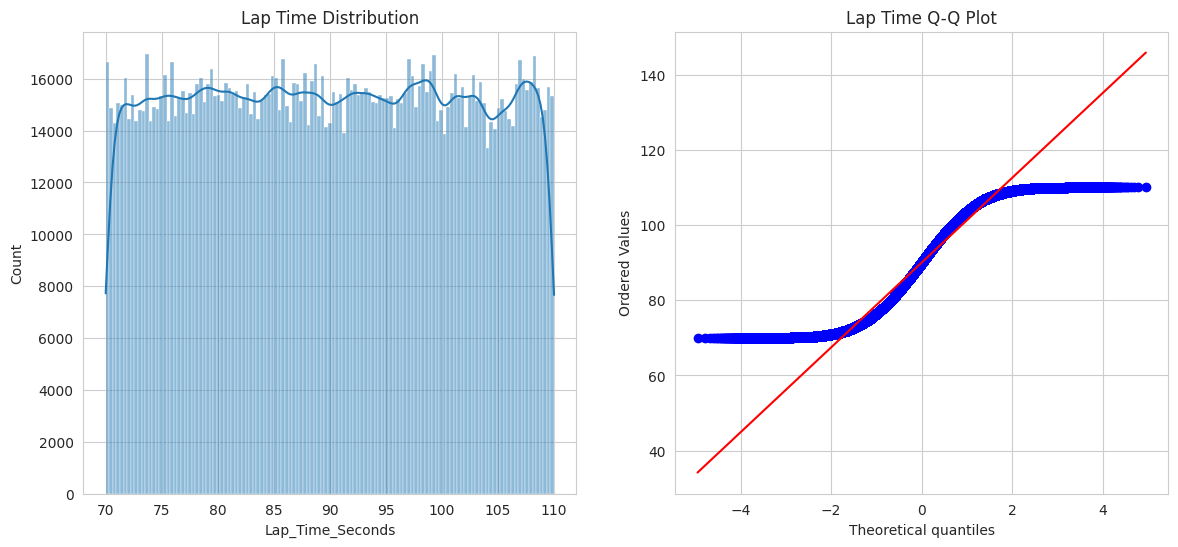


DATA VISUALIZATIONS

=== Correlation Matrix ===


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


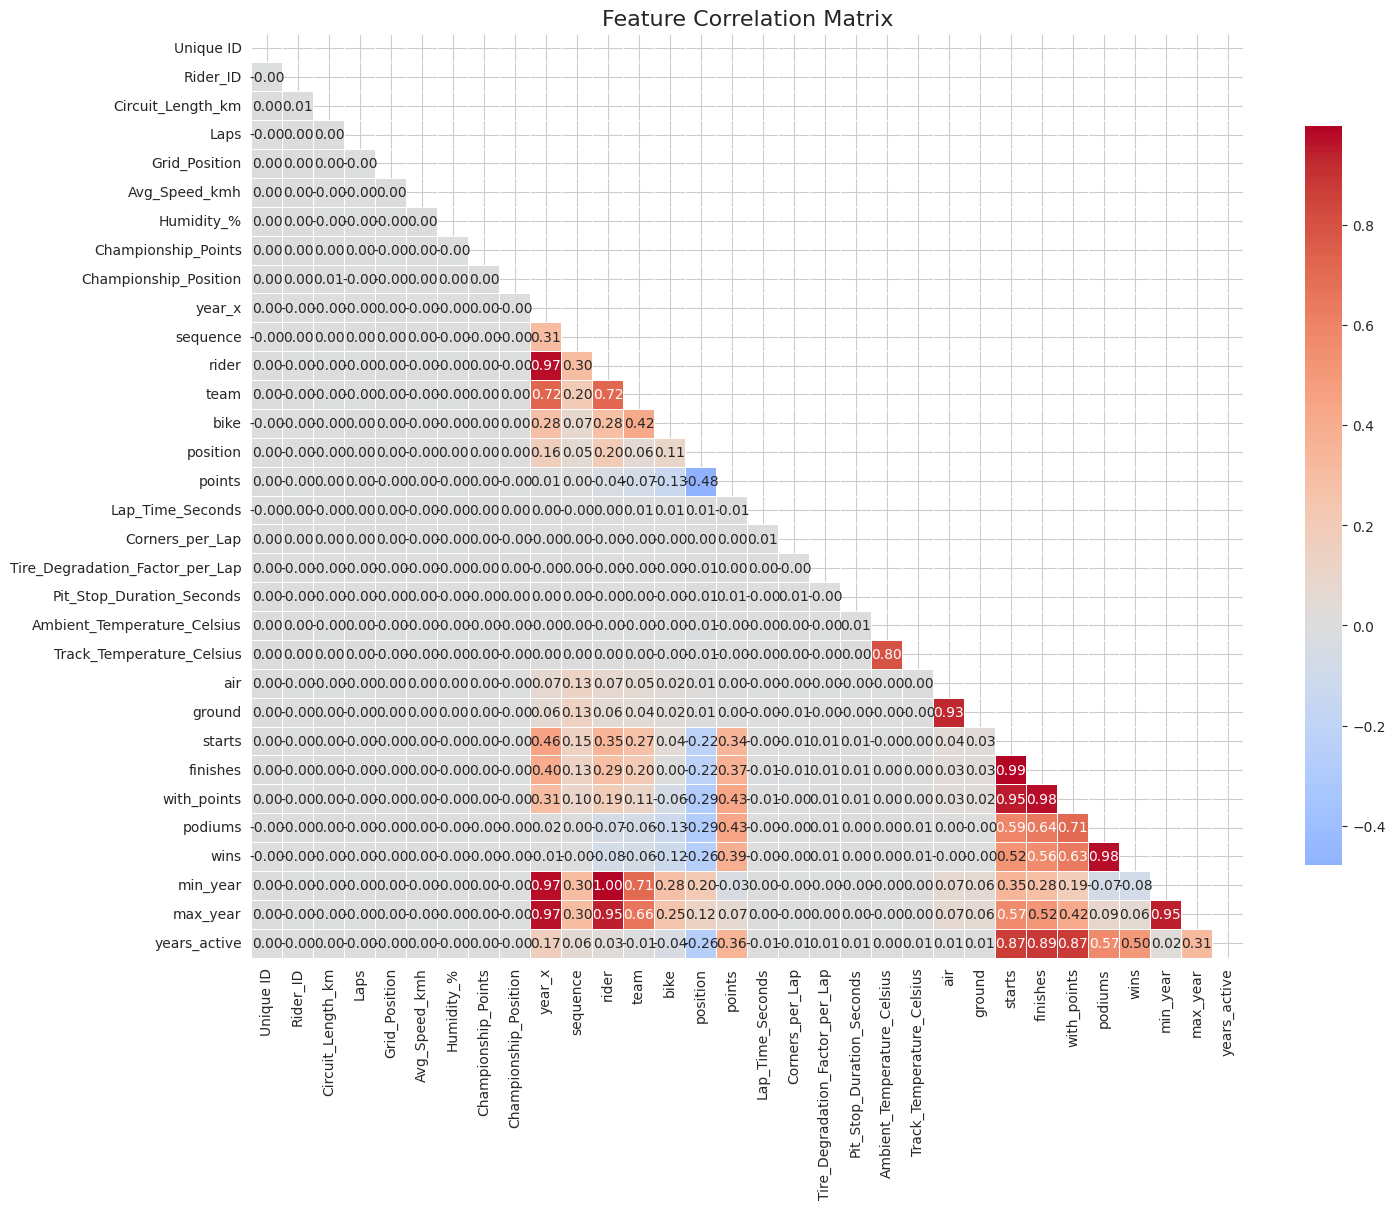


Top 10 Features Correlated with Lap Time:
Corners_per_Lap        0.008514
team                   0.007372
bike                   0.006116
position               0.005892
rider                  0.003797
min_year               0.003543
year_x                 0.001710
max_year               0.001005
Championship_Points    0.000837
Grid_Position          0.000746
Name: Lap_Time_Seconds, dtype: float64

=== Categorical Feature Distributions ===


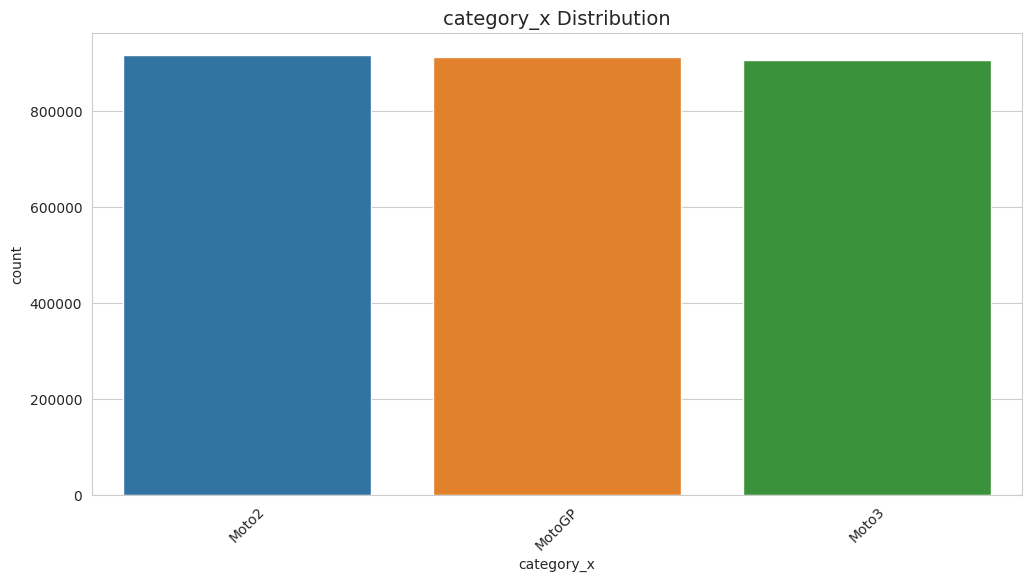

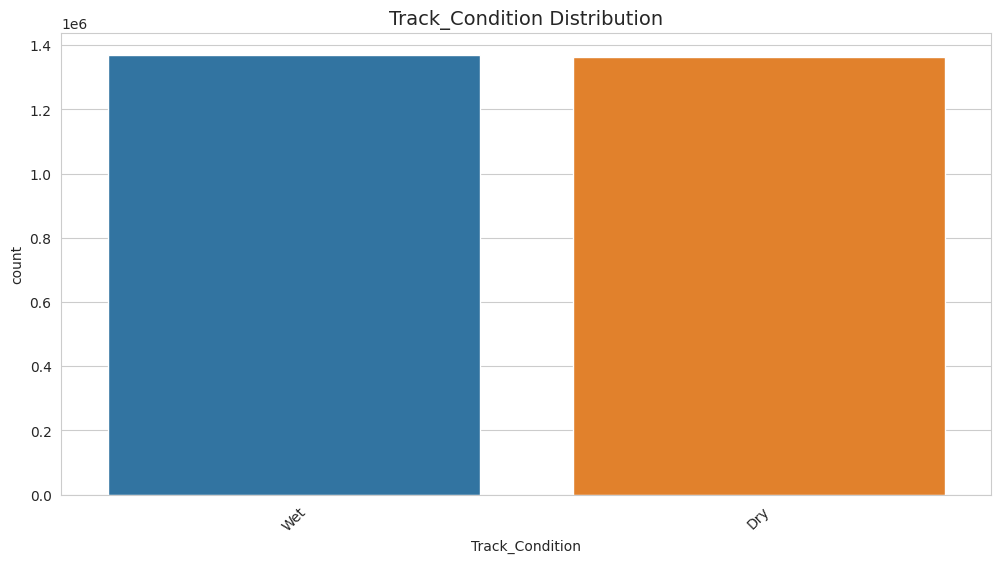

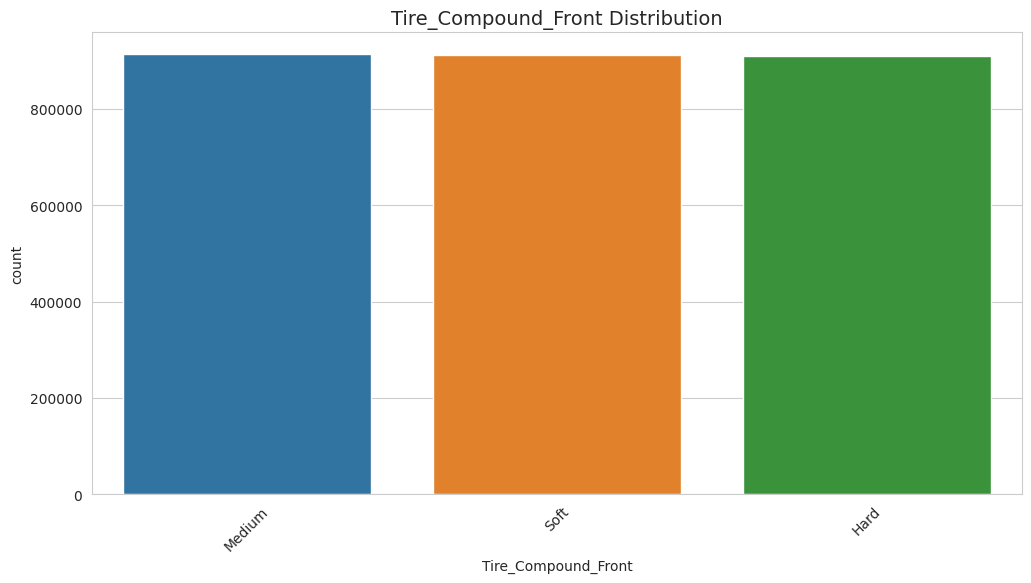

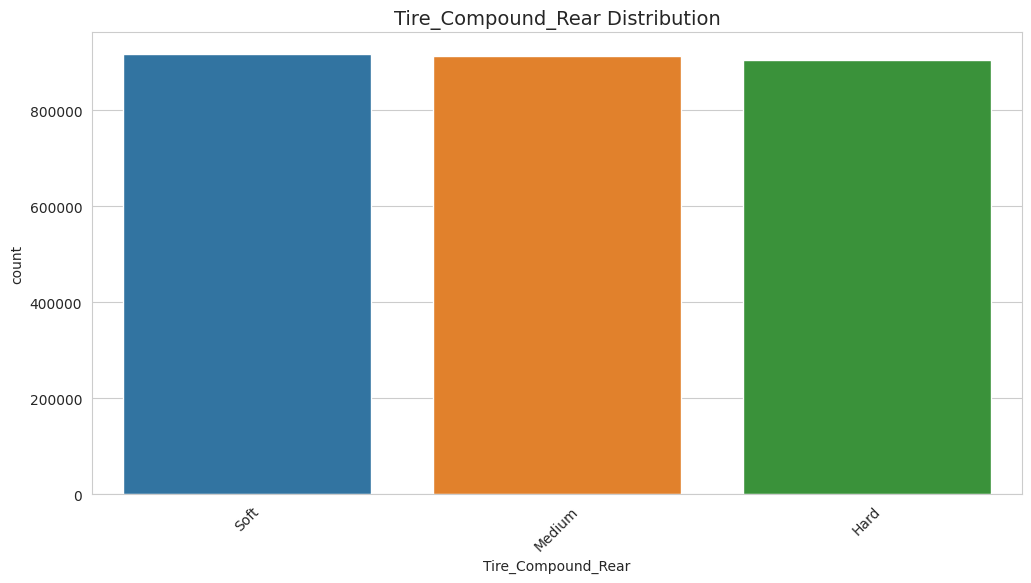

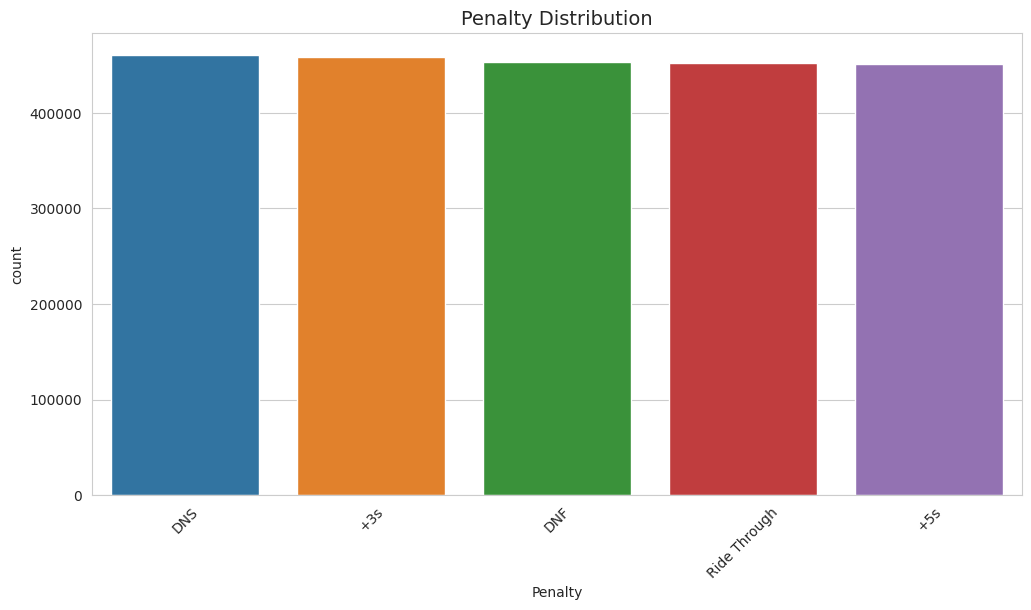


=== Numerical Feature Distributions ===


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


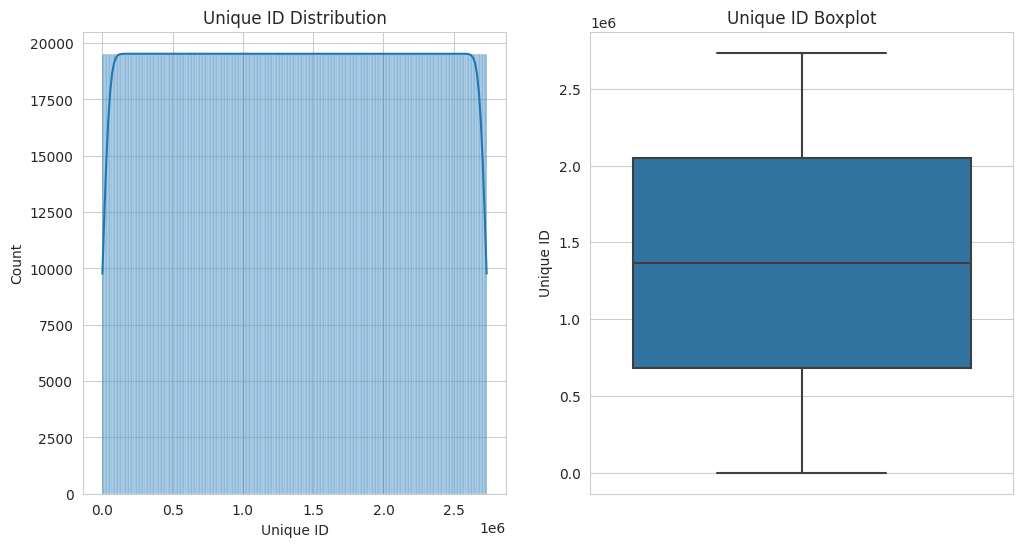

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


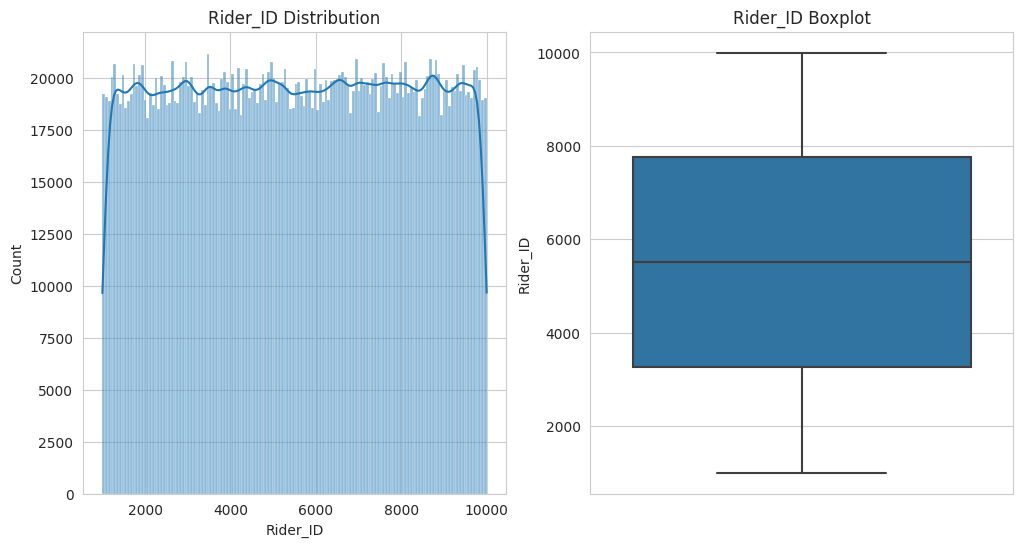

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


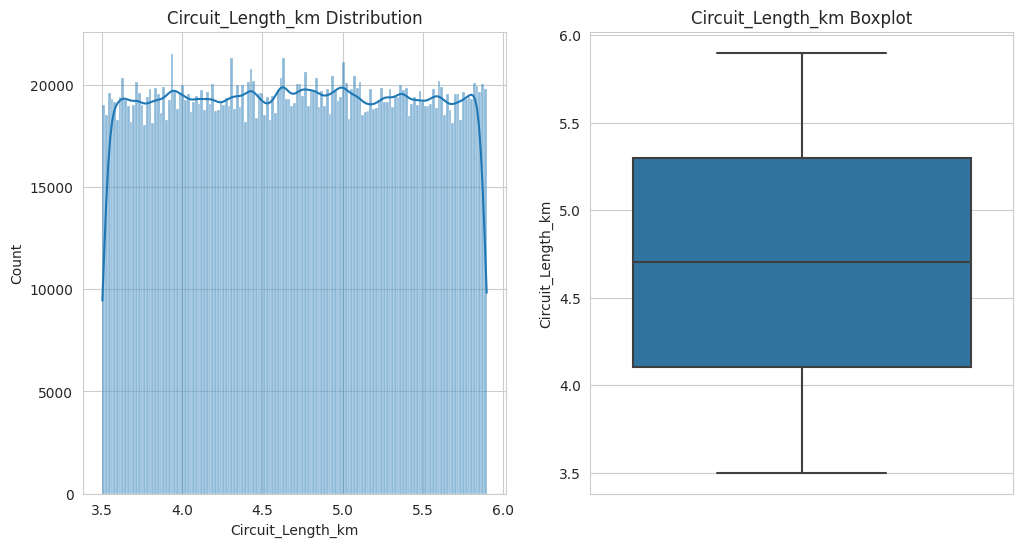

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


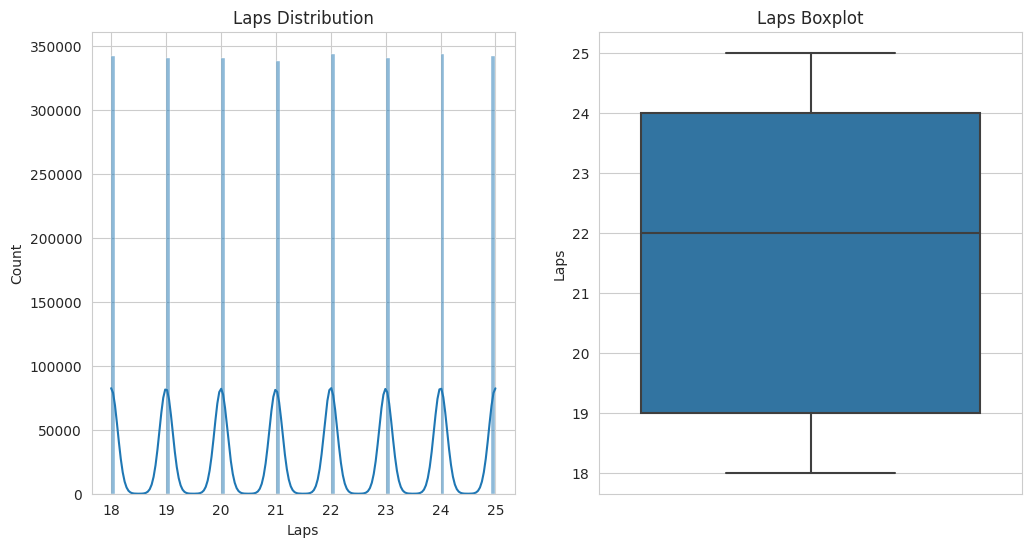

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


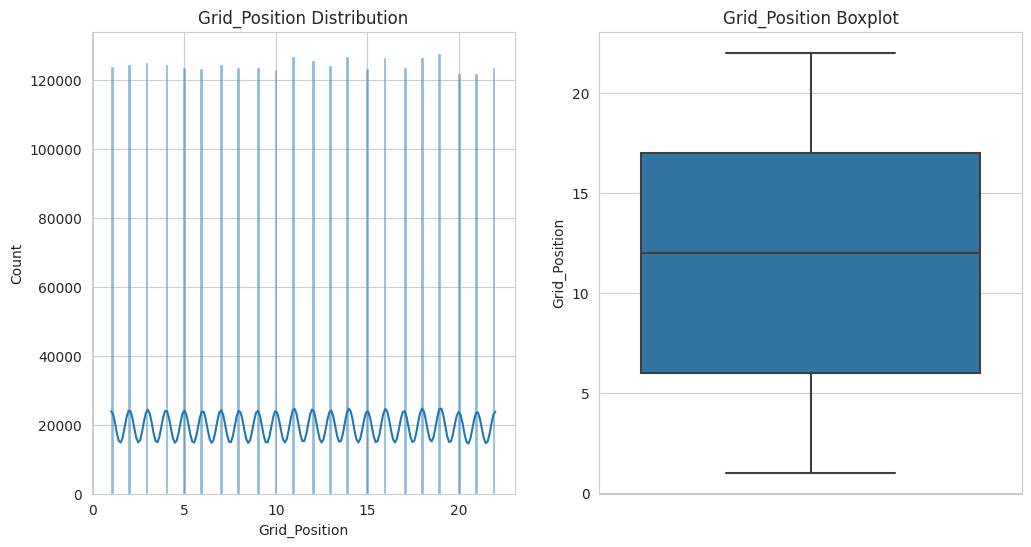


=== Yearly Lap Time Trends ===


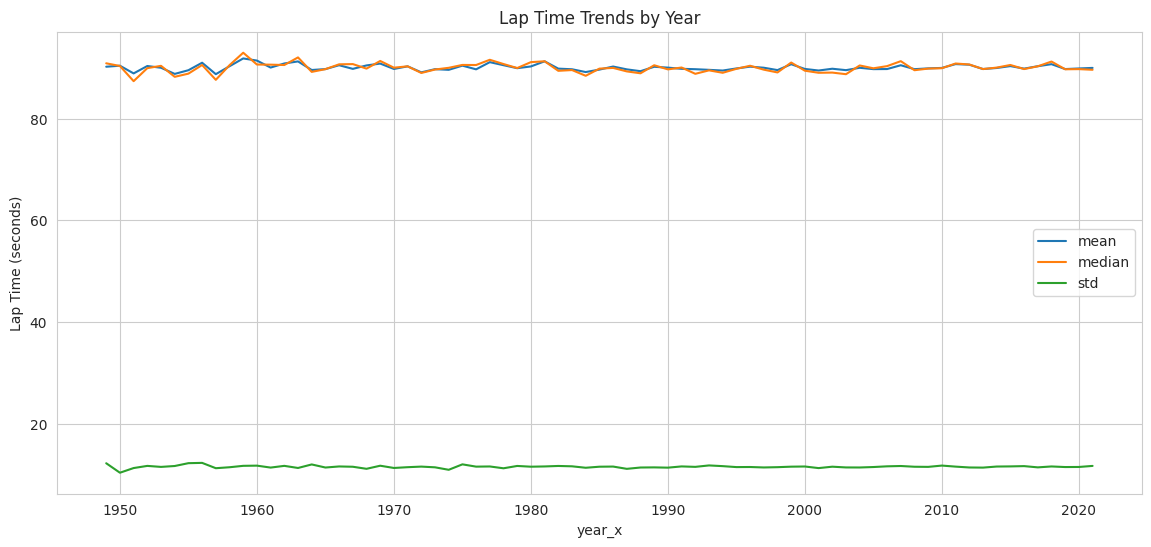


FEATURE ENGINEERING EXPLORATION

=== Engineered Feature: Speed Ratio ===


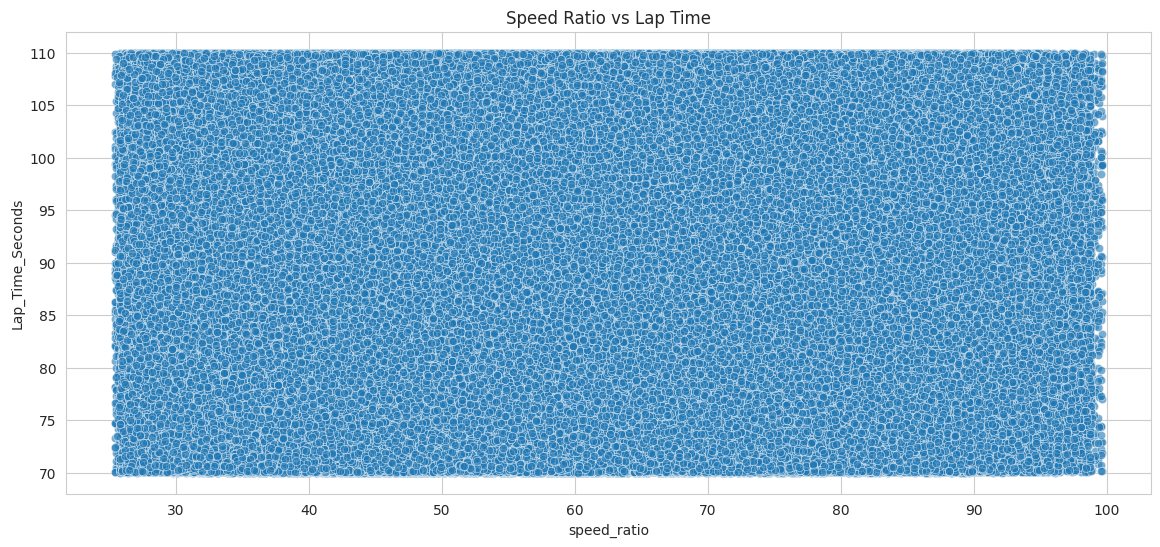


=== Engineered Feature: Tire Wear Estimate ===


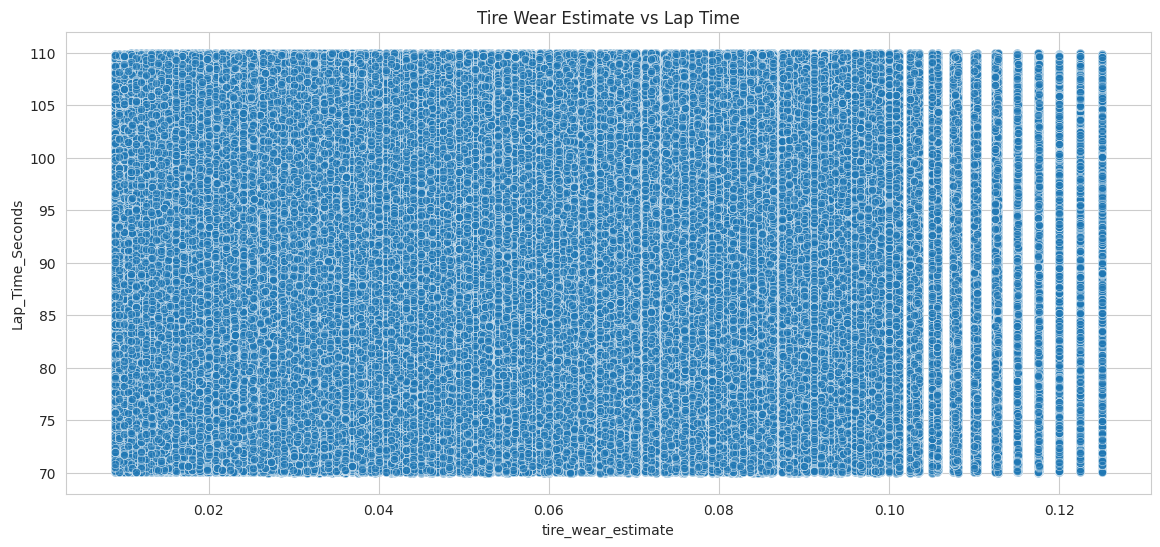


=== Engineered Feature: Rider Experience ===


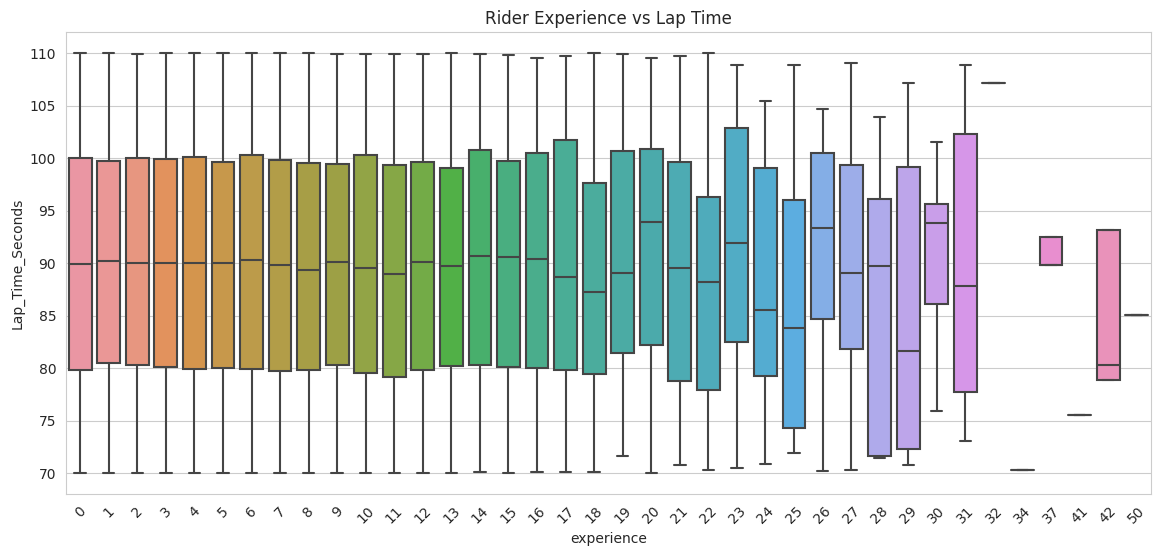


EDA completed successfully! Visualizations saved.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import missingno as msno
import plotly.express as px

# Set up visualization style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
pd.set_option('display.max_columns', 100)

# Load datasets
train = pd.read_csv('/kaggle/input/burnout-datathon-ieeecsmuj/train.csv')
val = pd.read_csv('/kaggle/input/burnout-datathon-ieeecsmuj/val.csv')
test = pd.read_csv('/kaggle/input/burnout-datathon-ieeecsmuj/test.csv')

# Combine datasets for comprehensive EDA
full_data = pd.concat([train, val, test], ignore_index=True)

# ==================================================
# 1. Dataset Overview
# ==================================================
print("="*50)
print("DATASET OVERVIEW")
print("="*50)

# Basic information
print("\n=== Dataset Shape ===")
print(f"Train shape: {train.shape}")
print(f"Validation shape: {val.shape}")
print(f"Test shape: {test.shape}")
print(f"Combined shape: {full_data.shape}")

# First look at data
print("\n=== First 5 Rows ===")
display(train.head())

# Data types and missing values
print("\n=== Data Types and Missing Values ===")
overview_df = pd.DataFrame({
    'dtype': full_data.dtypes,
    'missing_values': full_data.isnull().sum(),
    'missing_%': (full_data.isnull().mean() * 100).round(2),
    'unique_values': full_data.nunique()
})
display(overview_df)

# Missing values visualization
print("\n=== Missing Values Matrix ===")
msno.matrix(full_data)
plt.title('Missing Values Overview', fontsize=16)
plt.savefig('missing_values_matrix.png', bbox_inches='tight')
plt.show()

# ==================================================
# 2. Descriptive Statistics
# ==================================================
print("\n" + "="*50)
print("DESCRIPTIVE STATISTICS")
print("="*50)

# Numerical features summary
print("\n=== Numerical Features Summary ===")
num_cols = full_data.select_dtypes(include=np.number).columns
display(full_data[num_cols].describe().T)

# Categorical features summary
print("\n=== Categorical Features Summary ===")
cat_cols = full_data.select_dtypes(exclude=np.number).columns
for col in cat_cols:
    print(f"\n{col}:\n{full_data[col].value_counts().head(10)}")

# Target variable analysis
print("\n=== Target Variable (Lap_Time_Seconds) Distribution ===")
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(train['Lap_Time_Seconds'], kde=True)
plt.title('Lap Time Distribution')

plt.subplot(1, 2, 2)
stats.probplot(train['Lap_Time_Seconds'], plot=plt)
plt.title('Lap Time Q-Q Plot')
plt.savefig('target_distribution.png', bbox_inches='tight')
plt.show()

# ==================================================
# 3. Data Visualizations
# ==================================================
print("\n" + "="*50)
print("DATA VISUALIZATIONS")
print("="*50)

# Correlation matrix
print("\n=== Correlation Matrix ===")
corr_matrix = train.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", 
            center=0, linewidths=.5, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix', fontsize=16)
plt.savefig('correlation_matrix.png', bbox_inches='tight')
plt.show()

# Top correlations with target
corr_with_target = corr_matrix['Lap_Time_Seconds'].sort_values(ascending=False)[1:11]
print("\nTop 10 Features Correlated with Lap Time:")
print(corr_with_target)

# Categorical feature distributions
print("\n=== Categorical Feature Distributions ===")
for col in cat_cols[:5]:  # First 5 categorical features
    plt.figure(figsize=(12, 6))
    order = full_data[col].value_counts().index[:10]  # Top 10 categories
    sns.countplot(data=full_data, x=col, order=order)
    plt.title(f'{col} Distribution', fontsize=14)
    plt.xticks(rotation=45)
    plt.savefig(f'{col}_distribution.png', bbox_inches='tight')
    plt.show()

# Numerical feature distributions
print("\n=== Numerical Feature Distributions ===")
for col in num_cols[:5]:  # First 5 numerical features
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(full_data[col], kde=True)
    plt.title(f'{col} Distribution')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(y=full_data[col])
    plt.title(f'{col} Boxplot')
    plt.savefig(f'{col}_distribution.png', bbox_inches='tight')
    plt.show()

# Time-based analysis
if 'year_x' in full_data.columns:
    print("\n=== Yearly Lap Time Trends ===")
    yearly_stats = train.groupby('year_x')['Lap_Time_Seconds'].agg(['mean', 'median', 'std'])
    yearly_stats.plot(figsize=(14, 6))
    plt.title('Lap Time Trends by Year')
    plt.ylabel('Lap Time (seconds)')
    plt.savefig('yearly_trends.png', bbox_inches='tight')
    plt.show()

# ==================================================
# 4. Feature Engineering (EDA-focused)
# ==================================================
print("\n" + "="*50)
print("FEATURE ENGINEERING EXPLORATION")
print("="*50)

# Create sample features for analysis
full_data['speed_ratio'] = full_data['Avg_Speed_kmh'] / full_data['Circuit_Length_km']
full_data['tire_wear_estimate'] = full_data['Tire_Degradation_Factor_per_Lap'] * full_data['Laps']
full_data['experience'] = full_data['year_x'] - full_data['min_year']

# Analyze created features
print("\n=== Engineered Feature: Speed Ratio ===")
plt.figure(figsize=(14, 6))
sns.scatterplot(data=full_data, x='speed_ratio', y='Lap_Time_Seconds', alpha=0.6)
plt.title('Speed Ratio vs Lap Time')
plt.savefig('engineered_speed_ratio.png', bbox_inches='tight')
plt.show()

print("\n=== Engineered Feature: Tire Wear Estimate ===")
plt.figure(figsize=(14, 6))
sns.scatterplot(data=full_data, x='tire_wear_estimate', y='Lap_Time_Seconds', alpha=0.6)
plt.title('Tire Wear Estimate vs Lap Time')
plt.savefig('engineered_tire_wear.png', bbox_inches='tight')
plt.show()

print("\n=== Engineered Feature: Rider Experience ===")
plt.figure(figsize=(14, 6))
sns.boxplot(data=full_data, x='experience', y='Lap_Time_Seconds')
plt.title('Rider Experience vs Lap Time')
plt.xticks(rotation=45)
plt.savefig('engineered_experience.png', bbox_inches='tight')
plt.show()

# Save EDA report
print("\nEDA completed successfully! Visualizations saved.")